<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier


In [ ]:
! pip install torch torchvision

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

In [ ]:
# Set device based on GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

# EfficientNet-B5 Loading

# Fine-tuning on Tiny ImageNet (Classifier)

In [ ]:
!pip install datasets
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:


import numpy as np
import torch
from datasets import load_dataset

from torch.utils.data import Dataset
import torchvision.transforms as transforms
# Define data transforms (resize to 224x224 for EfficientNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from datasets import load_dataset

imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
imagenet_val_combined = load_dataset('Maysee/tiny-imagenet', split='valid')

imagenet_val_test = imagenet_val_combined.train_test_split(test_size=0.5, stratify_by_column='label')
imagenet_val = imagenet_val_test['train']
imagenet_test = imagenet_val_test['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
imagenet_val_combined

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [ ]:
import torch
from torch.utils.data import Dataset


class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageNetDataset(imagenet_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = ImageNetDataset(imagenet_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = ImageNetDataset(imagenet_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import tqdm
def train(model, train_dataloader, criterion, optimizer):
  model.train()
  train_loss = 0
  num_correct = 0
  for images, labels in tqdm.tqdm(train_dataloader, dynamic_ncols=True, leave=False, position=0):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    train_loss += loss.item()
    correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
    num_correct += correct

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(f"Train loss: {train_loss/len(train_dataloader.dataset)} | Accuracy: {num_correct/len(train_dataloader.dataset)}")
  return train_loss/len(train_dataloader.dataset), num_correct/len(train_dataloader.dataset)

def test(model, val_dataloader, criterion):
  model.eval()
  correct = 0
  test_loss = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm.tqdm(val_dataloader, dynamic_ncols=True, leave=False, position=0):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Test loss: {test_loss/len(val_dataloader.dataset)} | Accuracy: {correct/total}")
  return test_loss/len(val_dataloader.dataset), correct / total

def run(model, n_epoch, train_dataloader, val_dataloader, criterion, optimizer):
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []

  # Save the best model at highest validation acc
  best_accuracy = 0.0
  best_model_path = 'fine_tune_classifier.pth'

  for epoch in range(n_epoch):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_acc = test(model, val_dataloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1}/{n_epoch}, Test Accuracy: {test_acc:.4f}")

    # update the best model pickle file
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")
  return train_losses, train_accs, test_losses, test_accs


In [ ]:
model = models.efficientnet_b0(pretrained=True)
num_classes = 200
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
# Fine-tuning EfficientNet-B0 (train + validation)
n_epoch = 10
train_losses, train_accs, test_losses, test_accs = run(model, n_epoch, train_dataloader, val_dataloader, criterion, optimizer)

Epoch: 0


Train loss: 0.032792903772592544 | Accuracy: 0.56381


Test loss: 0.015028317999839783 | Accuracy: 0.7578
Epoch 1/10, Test Accuracy: 0.7578
New best model saved with accuracy: 0.7578
Epoch: 1


Train loss: 0.014398164306879043 | Accuracy: 0.76129


Test loss: 0.012948527091741562 | Accuracy: 0.7878
Epoch 2/10, Test Accuracy: 0.7878
New best model saved with accuracy: 0.7878
Epoch: 2


Train loss: 0.010629822035431861 | Accuracy: 0.81705


Test loss: 0.012626438879966735 | Accuracy: 0.791
Epoch 3/10, Test Accuracy: 0.7910
New best model saved with accuracy: 0.7910
Epoch: 3


Train loss: 0.008314216986894607 | Accuracy: 0.85382


Test loss: 0.012627843952178955 | Accuracy: 0.7946
Epoch 4/10, Test Accuracy: 0.7946
New best model saved with accuracy: 0.7946
Epoch: 4


Train loss: 0.006574498575180769 | Accuracy: 0.88233


Test loss: 0.012723494112491608 | Accuracy: 0.7988
Epoch 5/10, Test Accuracy: 0.7988
New best model saved with accuracy: 0.7988
Epoch: 5


Train loss: 0.005341439339593053 | Accuracy: 0.90249


Test loss: 0.013239056265354156 | Accuracy: 0.7968
Epoch 6/10, Test Accuracy: 0.7968
Epoch: 6


Train loss: 0.0043993667785078286 | Accuracy: 0.91889


Test loss: 0.013499124401807784 | Accuracy: 0.797
Epoch 7/10, Test Accuracy: 0.7970
Epoch: 7


Train loss: 0.003732672043889761 | Accuracy: 0.93005


Test loss: 0.014249138230085372 | Accuracy: 0.793
Epoch 8/10, Test Accuracy: 0.7930
Epoch: 8


Train loss: 0.00322058037687093 | Accuracy: 0.9403


Test loss: 0.014375376254320145 | Accuracy: 0.7994
Epoch 9/10, Test Accuracy: 0.7994
New best model saved with accuracy: 0.7994
Epoch: 9


Train loss: 0.0027980716752633453 | Accuracy: 0.94817


Test loss: 0.014846558880805969 | Accuracy: 0.7892
Epoch 10/10, Test Accuracy: 0.7892


In [ ]:
# Testing EfficientNet-B0 (Test)
model.load_state_dict(torch.load('fine_tune_classifier.pth'))
test_loss, test_acc = test(model, test_dataloader, criterion)

<ipython-input-33-794119c6b837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tune_classifier.pth'))
                              

Test loss: 0.0147994544506073 | Accuracy: 0.792


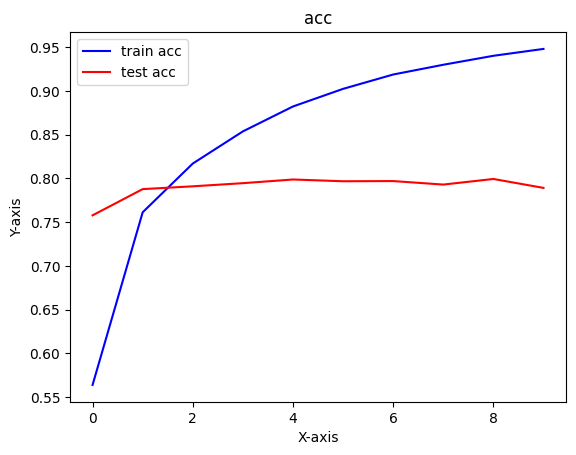

In [ ]:
import matplotlib.pyplot as plt

# Plot
epochs = [i for i in range(n_epoch)]

plt.plot(epochs, train_accs, label='train acc', color='blue')

# Plot the second line
plt.plot(epochs, test_accs, label='test acc', color='red')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('acc')

# Show legend to differentiate between the lines
plt.legend()

# Display the plot
plt.show()

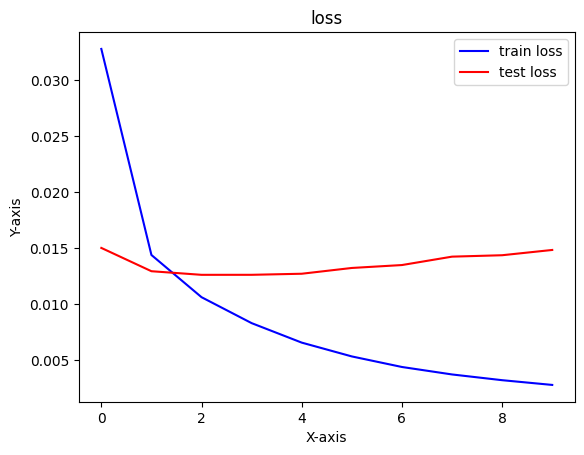

In [ ]:
# Plot
epochs = [i for i in range(n_epoch)]

plt.plot(epochs, train_losses, label='train loss', color='blue')

# Plot the second line
plt.plot(epochs, test_losses, label='test loss', color='red')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('loss')

# Show legend to differentiate between the lines
plt.legend()

# Display the plot
plt.show()